### 2. Boston & San Francisco Airbnb - Feature Analysis

### Imports

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
import json
import csv

from scipy import stats
from sklearn.preprocessing import MinMaxScaler


In [2]:
# Variables
target_name='price'

### Functions

In [3]:
# These functions are used to support the analysis below

def drop_column(dataframe,columnName):
    """
    Conditionaly drop columns if they exist
    """
    for cn in columnName:
        if(cn in dataframe.columns):
            dataframe.drop(cn, axis=1,inplace=True)
            
def print_datatypes(dataframe):
    """
    Print Datatypes of columns in a dataframe
    
    dataframe - pd.DataFrame to process
    """
    for x in dataframe.columns:
        print(dataframe[x].name, " : ", dataframe[x].dtype)
            
def replace_null_to_zero_float(dataframe,columnName):
    """
    Replace null in column with 0.0 float
    
    dataframe - pd.DataFrame to process
    columnName - column name of column to process
    """
    dataframe[columnName] = dataframe[columnName].fillna('0.0')
    dataframe[columnName] = dataframe[columnName].astype(float)
            
def bath_arithmetic(dataframe,columnName):
        """
        Replace bathroom text field with apprasal of number of baths
        
        dataframe - pd.DataFrame to process
        columnName - column name of column to process
        """
        dataframe[columnName] = dataframe[columnName].fillna('0')
        dataframe[columnName] = dataframe[columnName].replace({'':'0'})
        dataframe[columnName] = dataframe[columnName].replace({'half-bath':'0.5','Half-bath':'0.5'},regex=True)
        if(dataframe[columnName].dtype==object):
            dataframe[columnName] = dataframe[columnName].str.replace(r"[a-zA-Z]|\s",'',regex=True)
        dataframe[columnName] = dataframe[columnName].astype(float)

def pearsonr_corr(X_train,y_train):
    """
    Calculate Pearson r correlation with pvalue
    
    X_train - features
    y_train - target
    """
    out_list=[]
    rating=""
    for colx in X_train.columns:
        corr_tuple = stats.stats.pearsonr(X_train[colx], y_train.iloc[:,0] )
        if(corr_tuple[1]<5E-2):
            rating="*"
        elif(corr_tuple[1]<1E-2):
            rating="**"
        elif(corr_tuple[1]<1E-3):
             rating="***"
        out_list.append([colx, corr_tuple[0], corr_tuple[1], rating])
        
    corr_df = pd.DataFrame(out_list, columns=["Features", "Correlation", "P-Value","Rating"])
    return corr_df

def get_rating(pvalue):
    """
    Calculate * rating for pvalue
    
    pvalue - to evaluate 
    
    returns string containing * rating
    """
    rating=""
    if(pvalue <= 5E-2):
        rating="*"
    if(pvalue <= 1E-2):
        rating="**"
    if(pvalue <= 1E-3):
        rating="***"
    return rating


def apply_min_max_scalar(dataframe):
    """
    Apply Min Max Scalar transform to columns of dataframe
    Applies to columns
    
    dataframe - DataFrame to apply
    
    returns- dataframe with Min Max Scalar transform
    """
    return dataframe.apply(lambda x: x/x.max(), axis=0)

def apply_min_max_scalar_to_columns(dataframe,columnName):
    """
    Apply Min Max Scalar transform to columns of dataframe
    Applies to columns
    
    dataframe - DataFrame to apply
    
    returns- dataframe with Min Max Scalar transform
    """
    for col in columnName:
        dataframe[col] = dataframe[col] / dataframe[col].max()
    return dataframe
    
def apply_get_dummies(dataframe, columns, prefix):
    """
    dataframe - dataframe to encode
    columns - columns list to encode
    prefix - prefixes list for new columns created
    
    returns - DataFrame with onehot encoding
    
    Use  pandas get_dummies to make one hot encoding
    Also fill in spaces in column names after the prefix and initial underscore
    """
    
    wdf = pd.get_dummies(dataframe,columns=columns,prefix=prefix, prefix_sep="_", drop_first=False, sparse=False)
    # Fix the spaces in columns name issue using get_dummies
    wdf.columns = wdf.columns.map(lambda x : x.replace(' ','_'))
    return wdf



def get_one_hot_stats(dataframe, prefix, target, limit=0.05):
    """
    Perform calculation of t statistic and pvalue for one hot fields
    Set limit to 0.05 or prefered pvalue threshold
    
    dataframe - DataFrame to process
    prefix - one encoding prefix
    target - field to calculate statistics for
    limit - pvalue threshold to use
    
    returns one hot encoded dataframe, list of column with pvalue above threshold to drop
    """
    output_df=pd.DataFrame()
    drop_list=[]
    for col in dataframe.columns:
        if col.startswith(prefix):
            count_true = dataframe[col].sum()
            if(count_true > 1 ): # watch out for cols with only one val 
                mean_true = dataframe[dataframe[col]==True][target].mean()
                mean_false = dataframe[dataframe[col]==False][target].mean()
                tstat, pvalue = stats.ttest_ind(dataframe[dataframe[col]==True][target],
                                           dataframe[dataframe[col]==False][target])
                if(pvalue < limit):
                    output_data = pd.DataFrame({"column_name" : [col], 't_statistic' : [tstat], 'pvalue' : [pvalue],
                                'mean_True' : [mean_true], 'mean_False' : [mean_false],
                                'count_true' : [count_true], 'mean_diff' : [mean_true - mean_false]})
                    output_df = output_df.append(output_data, ignore_index=True)
                    output_df.sort_values(by=['mean_diff'], ascending=False)
                else:
                    drop_list.append(col)
            else:
                print ("Rejecting column!", col , ", reason low count ", count_true )
                drop_list.append(col)
        
        
    return output_df , drop_list       

def data_to_csv(dataframe, fname):
    """
    Export dataframe to csv file
    
    dataframe - dataframe to export
    fname - filename of csv file
    """
    dataframe.to_csv(path_or_buf=fname, sep=';', na_rep='', float_format=None, columns=None,
          header=True, index=False, index_label="Index", mode='w', encoding='utf-8', compression='infer',
          quoting=csv.QUOTE_NONNUMERIC, quotechar='"', line_terminator=None, chunksize=None, date_format=None,
          doublequote=True, escapechar=None, decimal='.', errors='strict', storage_options=None)

### Maps of Listing Price

<a href="https://public.tableau.com/views/AirbnbListings_16232780218150/BostonListingPrice?:language=en-GB&:display_count=n&:origin=viz_share_link">Boston Listing Price</a>

Run the cells to view the maps.

In [4]:
%%HTML
<div class='tableauPlaceholder' id='viz1623278178904' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ai&#47;AirbnbListings_16232780218150&#47;BostonListingPrice&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='AirbnbListings_16232780218150&#47;BostonListingPrice' /><param name='tabs' value='yes' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ai&#47;AirbnbListings_16232780218150&#47;BostonListingPrice&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en-GB' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1623278178904');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

[Boston Listing Price](https://public.tableau.com/views/AirbnbListings_16232780218150/BostonListingPrice?:language=en-GB&:display_count=n&:origin=viz_share_link)

In [5]:
%%HTML
<div class='tableauPlaceholder' id='viz1623278069044' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ai&#47;AirbnbListings_16232780218150&#47;SanFranciscoListingPrice&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='AirbnbListings_16232780218150&#47;SanFranciscoListingPrice' /><param name='tabs' value='yes' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ai&#47;AirbnbListings_16232780218150&#47;SanFranciscoListingPrice&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en-GB' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1623278069044');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

[San Francisco Listing Price](https://public.tableau.com/views/AirbnbListings_16232780218150/SanFranciscoListingPrice?:language=en-GB&:display_count=n&:origin=viz_share_link)

#### Relationship between location and price. 
Looking a the maps one might expect that the distribution of prices reflect real estate valuations. However it is not easy to perceive a relation between location and price. If you look hard enough you can find clusters of listings with similar prices but it is difficult to relate this to neighbourhood or the geo location fields. The majority of listings are either complete home/apt or private rooms, with hotel and shared rooms being minority categories in the listings.

### Load tidied data
Load the tidied data from the first notebook.

In [6]:
bdf = pd.read_csv("Boston_airbnb_listings_tidied.csv",sep=';', encoding='utf8')
sfdf = pd.read_csv("San_Francisco_airbnb_listings_tidied.csv",sep=';', encoding='utf8')

In [7]:
# Check Data was loaded
print('bdf shape',bdf.shape )
print('sfdf shape', sfdf.shape)

bdf shape (3142, 61)
sfdf shape (6681, 61)


In [8]:
# Print columns containing nulls
for col in bdf.columns:
    cnt= bdf[col].isnull().sum()
    if(cnt>0):
        print(col, cnt)
            

In [9]:
# Check Nulls
print(np.sum(bdf.isnull().sum()))
print(np.sum(sfdf.isnull().sum()))

0
0


In [10]:
# Display loaded data
bdf.head(5)

,id,listing_url,scrape_id,last_scraped,name,picture_url,host_id,host_url,host_since,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,Dataset
0,3781,https://www.airbnb.com/rooms/3781,20210420194355,2021-04-21,HARBORSIDE-Walk to subway,https://a0.muscache.com/pictures/24670/b2de044...,4804,https://www.airbnb.com/users/show/4804,2008-12-03,100.0,41.0,False,5.0,5.0,"['email', 'phone', 'reviews']",True,False,East Boston,42.36413,-71.02991,Entire apartment,Entire home/apt,2,1 bath,1.0,0.0,"[""Washer"", ""Dishwasher"", ""Refrigerator"", ""Pati...",125.0,32,1125,32.0,32.0,1125.0,1125.0,32.0,1125.0,True,1,1,1,106,2021-04-21,19,3,0,2015-07-10,2021-02-26,99.0,10.0,10.0,10.0,10.0,10.0,10.0,False,1,1,0,0,0.27,Boston
1,6695,https://www.airbnb.com/rooms/6695,20210420194355,2021-04-21,$99 Special!! Home Away! Condo,https://a0.muscache.com/pictures/38ac4797-e7a4...,8229,https://www.airbnb.com/users/show/8229,2009-02-19,0.0,0.0,True,4.0,4.0,"['email', 'phone', 'reviews', 'kba']",True,True,Roxbury,42.32802,-71.09387,Entire condominium,Entire home/apt,4,1 bath,1.0,1.0,"[""Washer"", ""Dishwasher"", ""Fire extinguisher"", ...",169.0,29,730,29.0,29.0,730.0,730.0,29.0,730.0,True,8,19,40,40,2021-04-21,115,0,0,2009-08-06,2019-11-02,96.0,10.0,10.0,10.0,10.0,9.0,10.0,False,4,4,0,0,0.81,Boston
2,10813,https://www.airbnb.com/rooms/10813,20210420194355,2021-04-23,"Back Bay Apt-blocks to subway, Newbury St, The...",https://a0.muscache.com/pictures/20b5b9c9-e1f4...,38997,https://www.airbnb.com/users/show/38997,2009-09-16,97.0,17.0,False,15.0,15.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",True,True,Back Bay,42.35061,-71.08787,Entire apartment,Entire home/apt,3,1 bath,0.0,1.0,"[""Wifi"", ""Kitchen"", ""Dishwasher"", ""Refrigerato...",96.0,29,1125,29.0,29.0,1125.0,1125.0,29.0,1125.0,True,29,59,63,307,2021-04-23,5,1,0,2016-05-23,2020-12-02,99.0,10.0,10.0,10.0,10.0,10.0,10.0,False,11,11,0,0,0.08,Boston
3,10986,https://www.airbnb.com/rooms/10986,20210420194355,2021-04-21,North End (Waterfront area) CLOSE TO MGH & SU...,https://a0.muscache.com/pictures/46994/567b606...,38997,https://www.airbnb.com/users/show/38997,2009-09-16,97.0,17.0,False,15.0,15.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",True,True,North End,42.36377,-71.05206,Entire condominium,Entire home/apt,2,1 bath,0.0,1.0,"[""Dishwasher"", ""Fire extinguisher"", ""Refrigera...",96.0,29,1125,29.0,29.0,1125.0,1125.0,29.0,1125.0,True,0,1,18,293,2021-04-21,2,0,0,2016-05-23,2016-05-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,11,11,0,0,0.03,Boston
4,13247,https://www.airbnb.com/rooms/13247,20210420194355,2021-04-21,Back Bay studio apartment,https://a0.muscache.com/pictures/miso/Hosting-...,51637,https://www.airbnb.com/users/show/51637,2009-11-05,0.0,0.0,False,0.0,0.0,"['email', 'phone']",True,False,Back Bay,42.35164,-71.08752,Entire home/apt,Entire home/apt,1,1 bath,0.0,0.0,"[""Washer"", ""Dishwasher"", ""Fire extinguisher"", ...",75.0,91,365,91.0,91.0,365.0,365.0,91.0,365.0,False,0,0,0,0,2021-04-21,0,0,0,1900-01-01,1900-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

### Neighbourhoods

In [11]:
# Create a dataframe to contain Neighbourhood OneHot encoding and cacluate stats
neighbourhood='neighbourhood_cleansed'
neighbourhood_prefix='nhd'
neighbourhood_data = pd.DataFrame(bdf[[neighbourhood,'price']])
neighbourhood_one_hot = apply_get_dummies(neighbourhood_data, columns=[neighbourhood], prefix=[neighbourhood_prefix])
neighbourhood_stats, drop_list = get_one_hot_stats(neighbourhood_one_hot,neighbourhood_prefix,'price', 0.05)
print(drop_list)
neighbourhood_stats.sort_values('pvalue',ascending=False)

Rejecting column! nhd_Leather_District , reason low count  1
['nhd_Allston', 'nhd_Back_Bay', 'nhd_Bay_Village', 'nhd_Beacon_Hill', 'nhd_Charlestown', 'nhd_Chinatown', 'nhd_Dorchester', 'nhd_East_Boston', 'nhd_Fenway', 'nhd_Hyde_Park', 'nhd_Jamaica_Plain', 'nhd_Leather_District', 'nhd_Longwood_Medical_Area', 'nhd_Mattapan', 'nhd_Mission_Hill', 'nhd_North_End', 'nhd_Roslindale', 'nhd_Roxbury', 'nhd_South_Boston', 'nhd_South_Boston_Waterfront', 'nhd_South_End', 'nhd_West_End', 'nhd_West_Roxbury']


,column_name,t_statistic,pvalue,mean_True,mean_False,count_true,mean_diff
1,nhd_Downtown,3.036002,0.002417,215.912162,158.957484,296,56.954678
0,nhd_Brighton,-3.051215,0.002298,101.362319,168.763543,207,-67.401225


## Explore Boston Neighbourhoods

[Boston Neighourhoods viz](https://public.tableau.com/app/profile/aitch/viz/AirbnbListings_16232780218150/BostonListingPrice)

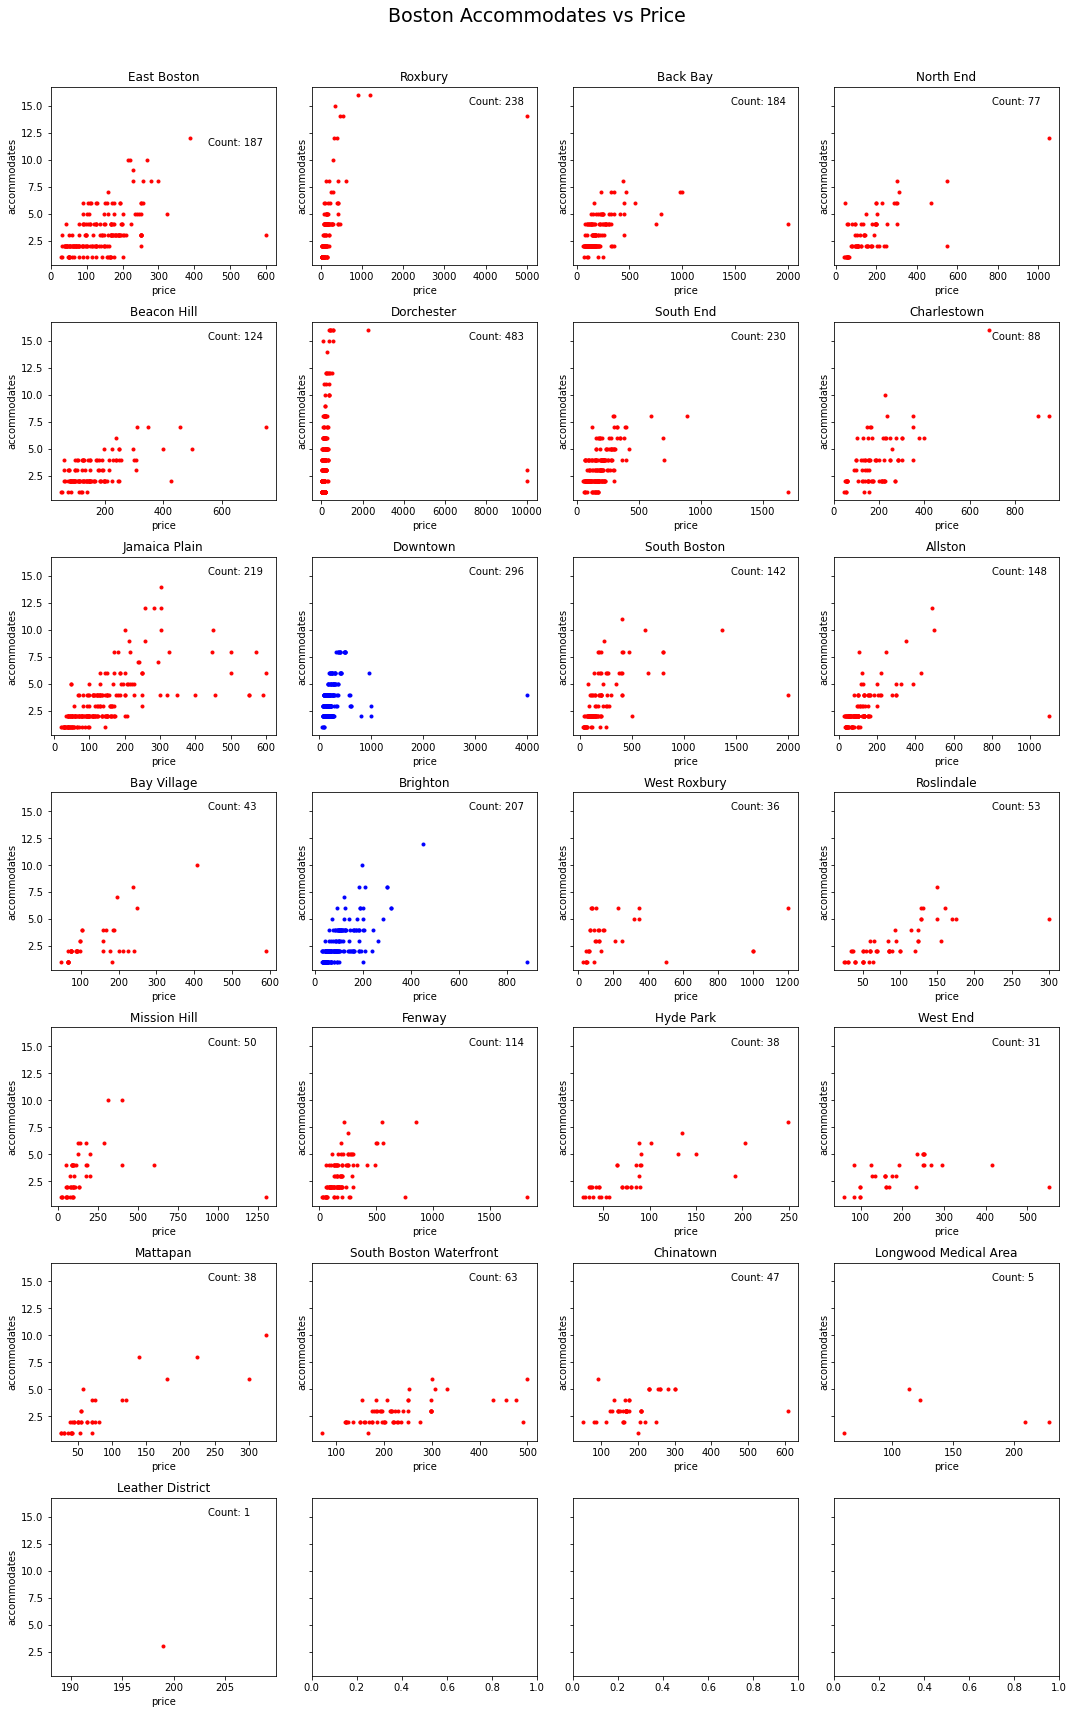

In [12]:
# Plot Neighbourhood Accomodates vs Prices
# text coordinates and content

cnt=0
xdim=4
ydim=7
xlim=xdim-1
ylim=ydim-1
x,y = 0,0
dot_size = (plt.rcParams['lines.markersize']/2) ** 2
fig,axes = plt.subplots(ydim,xdim,sharey=True,figsize=(15,25))

for nh in bdf[neighbourhood].unique():
    nbh=bdf[bdf[neighbourhood]==nh]
    
    
    if (nh in ['Brighton','Downtown']):
        c='b'
    else:
        c='r'  
    
    
    axes[y,x].scatter(nbh['price'], nbh['accommodates'], color=c, s=dot_size)
    
    # Present distribution of price only
    #ones=[1]*len(nbh)
    #axes[y,x].scatter(nbh['price'],ones,color=c,s=dot_size)
    
    axes[y,x].title.set_text(nh)
    axes[y,x].set_xlabel('price')
    axes[y,x].set_ylabel('accommodates')
    
    x_coord = axes[y,x].get_xlim()[0] + (axes[y,x].get_xlim()[-1] - axes[y,x].get_xlim()[0])*0.7
    y_coord = axes[y,x].get_ylim()[0] + (axes[y,x].get_ylim()[-1] - axes[y,x].get_ylim()[0])*0.9
    
    axes[y,x].text(x = x_coord, y = y_coord  , s = 'Count: {}'.format(len(nbh)) )
    x+=1
    if(x>xlim):
        x=0
        y+=1
    cnt+=1    
    if(cnt> len(bdf[neighbourhood].unique())):
        break
        
fig.tight_layout(rect=[0, 0.03, 1, 0.95],pad=1.0)
fig.suptitle("Boston Accommodates vs Price",fontsize=19)
plt.show()

The plot above shows Accommodates vs Price for each Neighbourhood. Accommodates has the highest pearson R coeffient ~0.6 of the features available so the scatter plots of accommodates and price illustrate strongest relation to price in the data set. Amoung these plots are those for Brighton and Downtown the only two that pass the ttest for their price distribution with a p value < 0.01.

In [13]:
# Add the neighbourhood short list into the dataset and see what happens
bdf= apply_get_dummies(bdf,[neighbourhood],[neighbourhood_prefix])
print(drop_list)
print(bdf.columns)

bdf = bdf.drop(drop_list, axis=1)

['nhd_Allston', 'nhd_Back_Bay', 'nhd_Bay_Village', 'nhd_Beacon_Hill', 'nhd_Charlestown', 'nhd_Chinatown', 'nhd_Dorchester', 'nhd_East_Boston', 'nhd_Fenway', 'nhd_Hyde_Park', 'nhd_Jamaica_Plain', 'nhd_Leather_District', 'nhd_Longwood_Medical_Area', 'nhd_Mattapan', 'nhd_Mission_Hill', 'nhd_North_End', 'nhd_Roslindale', 'nhd_Roxbury', 'nhd_South_Boston', 'nhd_South_Boston_Waterfront', 'nhd_South_End', 'nhd_West_End', 'nhd_West_Roxbury']
Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'picture_url',
       'host_id', 'host_url', 'host_since', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maxi

### San Francisco Neighbourhoods

[San francisco Neighbourhoods](https://public.tableau.com/app/profile/aitch/viz/AirbnbListings_16232780218150/BostonListingPrice)

In [14]:
# Create a dataframe to contain Neighbourhood OneHot encoding and cacluate stats

neighbourhood='neighbourhood_cleansed'
neighbourhood_prefix='nhd'
neighbourhood_data = pd.DataFrame(sfdf[[neighbourhood,'price']])
sfdf_neighbourhoods_unique = sfdf[neighbourhood].unique()
neighbourhood_one_hot = apply_get_dummies(neighbourhood_data, columns=[neighbourhood], prefix=[neighbourhood_prefix])

neighbourhood_stats, drop_list = get_one_hot_stats(neighbourhood_one_hot,neighbourhood_prefix,'price', 0.05)

print(drop_list)
neighbourhood_stats.sort_values('pvalue', ascending=False)

['nhd_Bayview', 'nhd_Bernal_Heights', 'nhd_Castro/Upper_Market', 'nhd_Chinatown', 'nhd_Crocker_Amazon', 'nhd_Diamond_Heights', 'nhd_Downtown/Civic_Center', 'nhd_Excelsior', 'nhd_Glen_Park', 'nhd_Golden_Gate_Park', 'nhd_Haight_Ashbury', 'nhd_Inner_Richmond', 'nhd_Inner_Sunset', 'nhd_Lakeshore', 'nhd_Marina', 'nhd_Mission', 'nhd_Nob_Hill', 'nhd_Noe_Valley', 'nhd_North_Beach', 'nhd_Ocean_View', 'nhd_Outer_Mission', 'nhd_Outer_Richmond', 'nhd_Pacific_Heights', 'nhd_Parkside', 'nhd_Potrero_Hill', 'nhd_Presidio', 'nhd_Presidio_Heights', 'nhd_Russian_Hill', 'nhd_Seacliff', 'nhd_South_of_Market', 'nhd_Visitacion_Valley', 'nhd_West_of_Twin_Peaks', 'nhd_Western_Addition']


,column_name,t_statistic,pvalue,mean_True,mean_False,count_true,mean_diff
1,nhd_Outer_Sunset,-2.030980,4.229655e-02,134.671937,223.569851,253,-88.897914
2,nhd_Twin_Peaks,3.168858,1.537295e-03,519.000000,217.859556,52,301.140444
0,nhd_Financial_District,9.525781,2.238160e-21,683.656085,206.711029,189,476.945056


So I will keep the Outer Sunset, Twin Peaks, and Financial District onehot features in the dataset and we can use them to build models based on the appreciation that they have significant influence on price compared to the fields that have not passed the test and will be removed. The strongest candidates can be retained in the dataset and further feature evaluation applied.

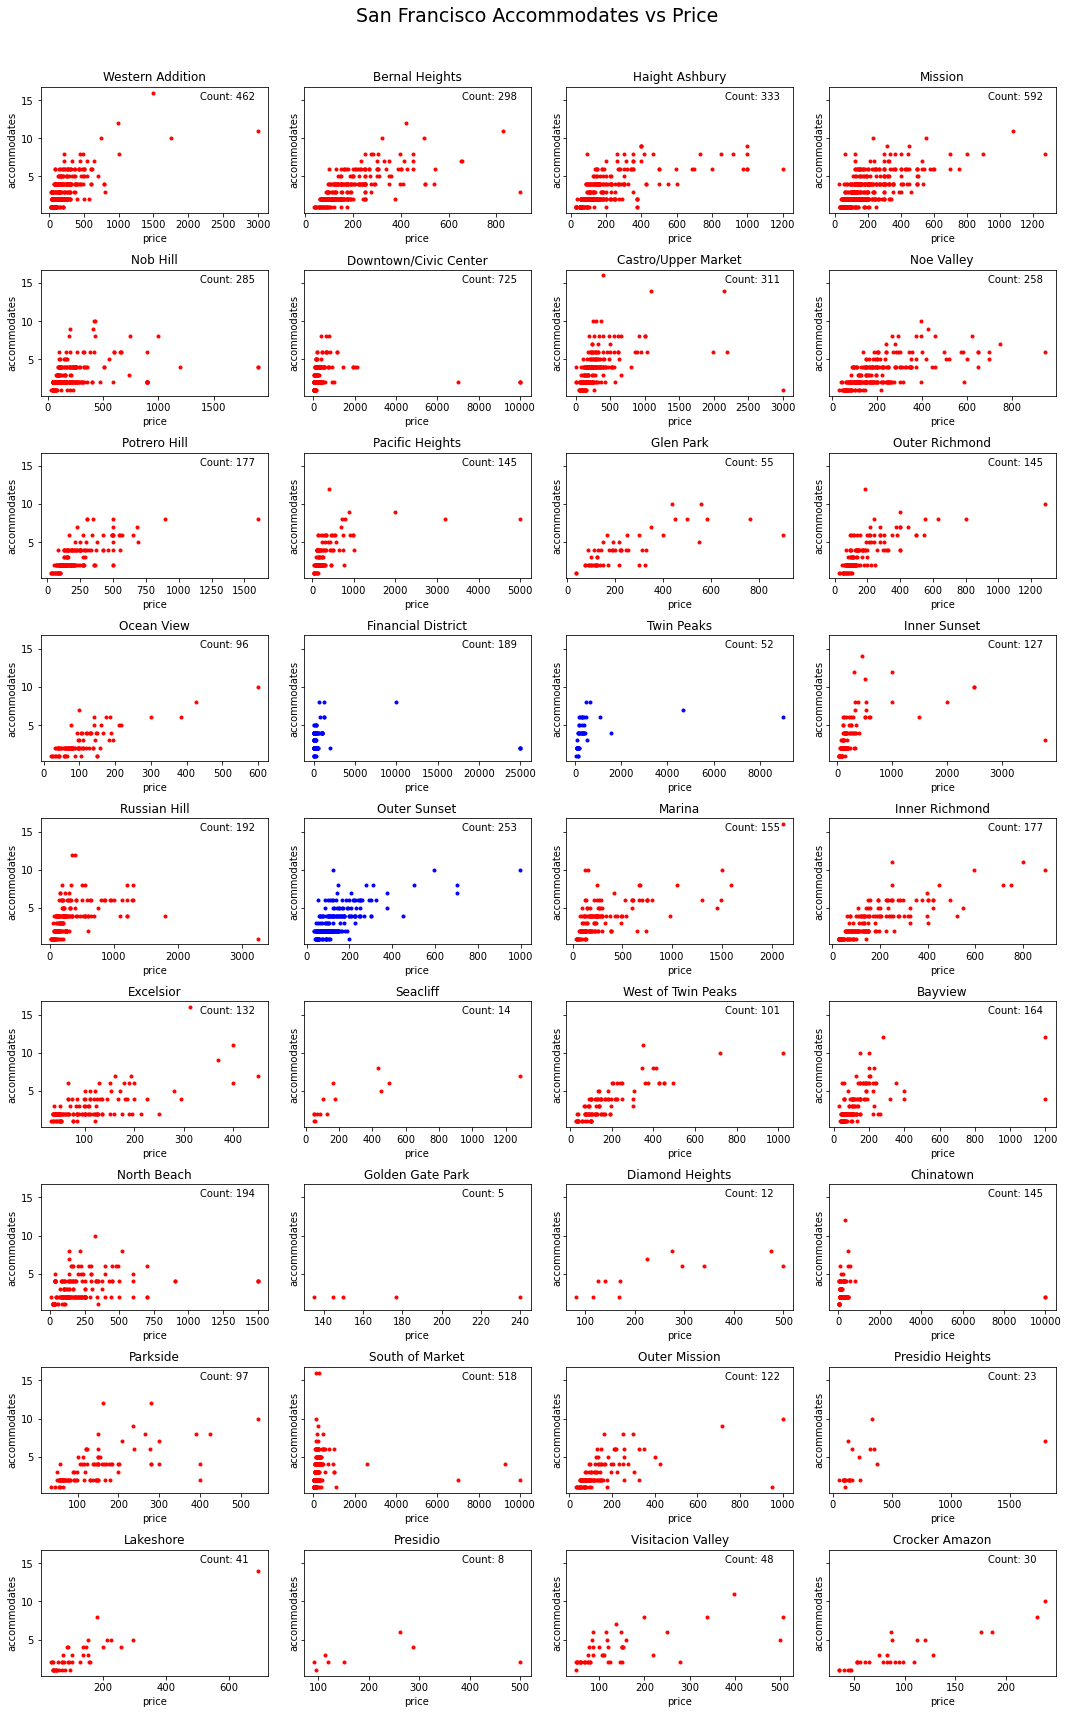

In [15]:
# Plot Neighbourhood Accomodates vs Prices
# text coordinates and content

cnt=0
xdim=4
ydim=9
xlim=xdim-1
ylim=ydim-1
x,y = 0,0
dot_size = (plt.rcParams['lines.markersize']/2) ** 2
fig,axes = plt.subplots(ydim, xdim, sharey=True,figsize=(15,25))


in_list= neighbourhood_stats['column_name'].str.replace('nhd_','').to_list()
in_list =  [x.replace('_', ' ') for x in in_list]


for nh in sfdf[neighbourhood].unique():
    nbh=sfdf[sfdf[neighbourhood]==nh]
    

    
    if (nh in in_list):
        c='b'
    else:
        c='r'  
    
    
    axes[y,x].scatter(nbh['price'], nbh['accommodates'], color=c, s=dot_size)
    
    # Present distribution of price only
    #ones=[1]*len(nbh)
    #axes[y,x].scatter(nbh['price'],ones,color=c,s=dot_size)
    
    axes[y,x].title.set_text(nh)
    axes[y,x].set_xlabel('price')
    axes[y,x].set_ylabel('accommodates')
    
    x_coord = axes[y,x].get_xlim()[0] + (axes[y,x].get_xlim()[-1] - axes[y,x].get_xlim()[0])*0.7
    y_coord = axes[y,x].get_ylim()[0] + (axes[y,x].get_ylim()[-1] - axes[y,x].get_ylim()[0])*0.9
    
    axes[y,x].text(x = x_coord, y = y_coord  , s = 'Count: {}'.format(len(nbh)) )
    x+=1
    if(x>xlim):
        x=0
        y+=1
    cnt+=1    
    if(cnt> len(sfdf[neighbourhood].unique())):
        break
        
fig.tight_layout(rect=[0, 0.03, 1, 0.95],pad=1.0)
fig.suptitle("San Francisco Accommodates vs Price",fontsize=19)
plt.show()

In [16]:
sfdf= apply_get_dummies(sfdf,[neighbourhood],[neighbourhood_prefix])


In [17]:
# drop the unwanted neighbourhoods
sfdf=sfdf.drop(drop_list, axis=1)

Looking at the tableau visualizations we can see that neighbourhood does not have an observable relationship with price. The majority of t-test results indicate that the relationship between neighbourhood and listing price is weak.

### Plot Price Distributions

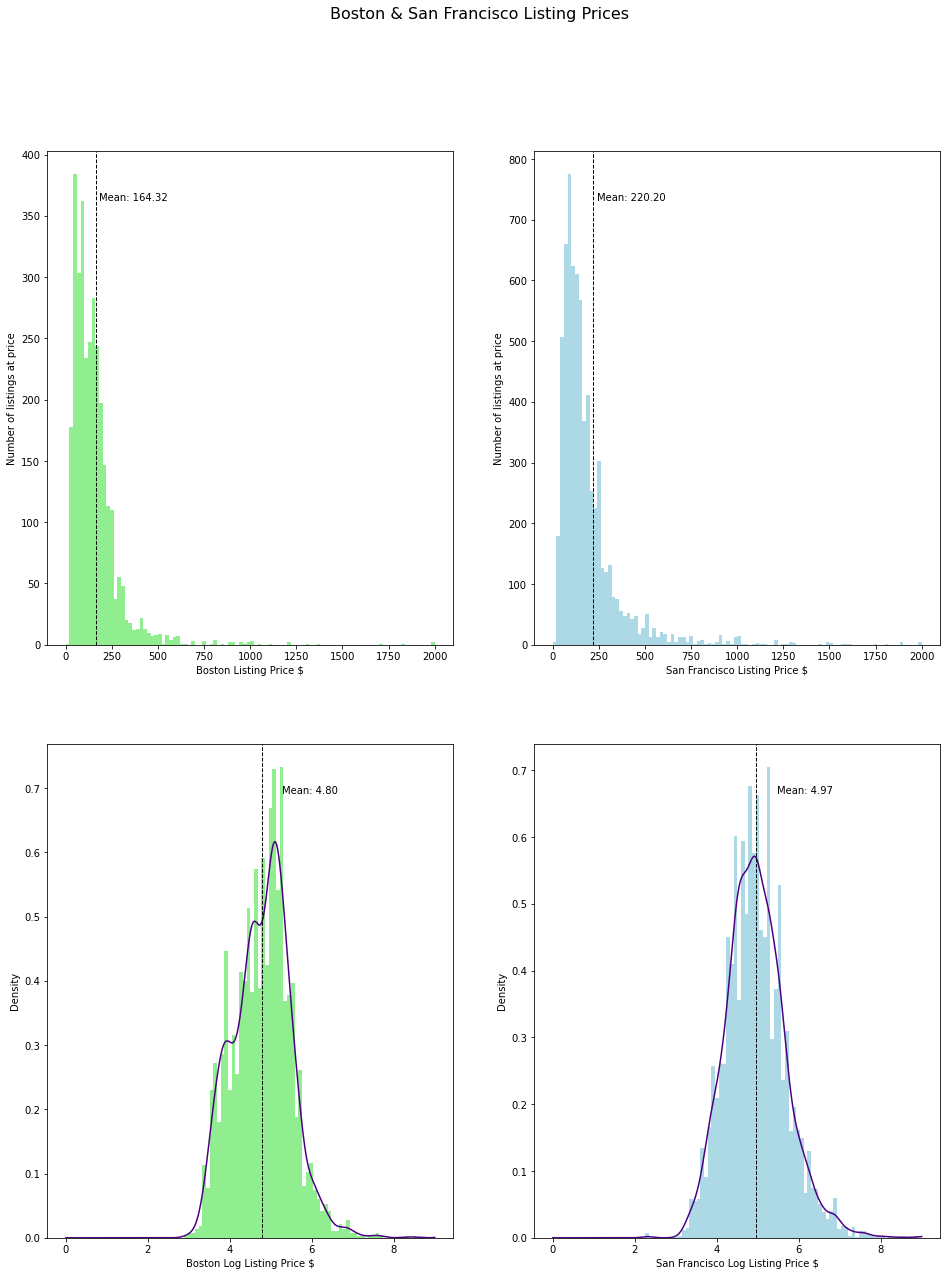

In [18]:
# Plot Price Distributions

fig, axes = plt.subplots(nrows=2,ncols=2)
fig.suptitle('Boston & San Francisco Listing Prices', fontsize=16)
fig.set_size_inches(16, 20)

axes[0,0].hist(bdf.price, bins=100, range=(0,2000), color='lightgreen')
axes[0,0].axvline(bdf.price.mean(), color='k', linestyle='dashed', linewidth=1)
axes[0,0].set_xlabel('Boston Listing Price $')
axes[0,0].set_ylabel('Number of listings at price')
axes[0,0].text(bdf.price.mean()*1.1, axes[0,0].get_ylim()[-1]*0.9, 'Mean: {:.2f}'.format(bdf.price.mean()))


kde2 = stats.gaussian_kde( np.log(bdf.price) )
nums = np.linspace(0,9,len(bdf.price))
axes[1,0].hist(np.log(bdf.price),density=True, bins=100,range=(0,9), color='lightgreen')
axes[1,0].plot(nums, kde2(nums), color='indigo')
axes[1,0].set_xlabel('Boston Log Listing Price $')
axes[1,0].set_ylabel('Density')
axes[1,0].axvline(np.log(bdf.price).mean(), color='k', linestyle='dashed', linewidth=1)
axes[1,0].text(np.log(bdf.price).mean()*1.1, axes[1,0].get_ylim()[-1]*0.9, 'Mean: {:.2f}'.format(np.log(bdf.price).mean()))

axes[0,1].hist(sfdf.price, bins=100,range=(0,2000), color='lightblue')
axes[0,1].axvline(sfdf.price.mean(), color='k', linestyle='dashed', linewidth=1)
axes[0,1].set_xlabel('San Francisco Listing Price $')
axes[0,1].set_ylabel('Number of listings at price')
axes[0,1].text(sfdf.price.mean()*1.1, axes[0,1].get_ylim()[-1]*0.9, 'Mean: {:.2f}'.format(sfdf.price.mean()))


kde4 =  stats.gaussian_kde( np.log(sfdf.price) )
nums=np.linspace(0,9,len(sfdf.price))
axes[1,1].hist(np.log(sfdf.price),density=True, bins=100,range=(0,9), color='lightblue')
axes[1,1].plot(nums,kde4(nums),color='indigo')
axes[1,1].set_xlabel('San Francisco Log Listing Price $')
axes[1,1].set_ylabel('Density')
axes[1,1].axvline(np.log(sfdf.price).mean(), color='k', linestyle='dashed', linewidth=1)
axes[1,1].text(np.log(sfdf.price).mean()*1.1, axes[1,1].get_ylim()[-1]*0.9, 'Mean: {:.2f}'.format(np.log(sfdf.price).mean()))


plt.show()

There are whiskers in the price distributions due to the tendancy of hosts to round listing prices up to a round number. Both the log price distributions have a fatter tail on the up side than the down, so are skewed to the right on these plots.

In [19]:
# Just a reminder of how percentage of area under bell curve relates to standard deviation
fraction_per_std=[0.3413, 0.1359, 0.0214, 0.0013]
f2=[element * 2 for element in fraction_per_std]
print("Fraction under both tails at 1,2,3,4 std", np.cumsum(f2))

Fraction under both tails at 1,2,3,4 std [0.6826 0.9544 0.9972 0.9998]


In [20]:
# Describe Price
boston_desc=pd.DataFrame(bdf.price).describe()
sanfran_desc=pd.DataFrame(sfdf.price).describe()

sanfran_desc
boston_desc
desc = pd.concat([boston_desc, sanfran_desc],axis=1)

In [21]:
# Calculate positions of outliers interms of standard deviation
mean=desc.iloc[1,0]
std=desc.iloc[2,0]
minval=desc.iloc[3,0]
maxval=desc.iloc[7,0]

print("Boston Listing Prices")
print("The minimum price value is ",np.round((mean-minval)/std,4)," standard deviations from the mean") 
print("The maximum price value is ",np.round((maxval-mean)/std,4)," standard deviations from the mean")
print()
mean=desc.iloc[1,1]
std=desc.iloc[2,1]
minval=desc.iloc[3,1]
maxval=desc.iloc[7,1]

print("San Francisco Listing Prices")
print("The minimum price value is ",np.round((mean-minval)/std,4)," standard deviations from the mean") 
print("The maximum price value is ",np.round((maxval-mean)/std,4)," standard deviations from the mean")

Boston Listing Prices
The minimum price value is  0.4725  standard deviations from the mean
The maximum price value is  31.9779  standard deviations from the mean

San Francisco Listing Prices
The minimum price value is  0.3077  standard deviations from the mean
The maximum price value is  36.2771  standard deviations from the mean


Text(0.5, 0, 'Price $')

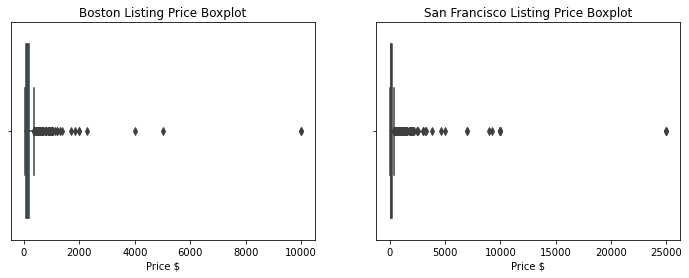

In [22]:
# Box Plot of price for Boston and San Francisco
fig, axes = plt.subplots(1,2,figsize=(12,4))

ax = sns.boxplot(ax=axes[0],x=bdf['price'])
ax.set_title("Boston Listing Price Boxplot")
ax.set_xlabel("Price $")

ax = sns.boxplot(ax=axes[1],x=sfdf['price'])
ax.set_title("San Francisco Listing Price Boxplot")
ax.set_xlabel("Price $")

So there are lots of outliers on the upside of the price distribution and none below.

### Further Data Processing

In [23]:
# Drop Text fields we don't need and will not use

text_fields=['listing_url','name','description','summary','picture_url','neighborhood_overview', 'host_name',
             'host_location','host_about','host_url','host_response_time','host_thumbnail_url', 'host_picture_url',
            'host_neighbourhood','neighbourhood','license','Dataset']

drop_column(bdf, text_fields)
drop_column(sfdf, text_fields)

us_fields=['has_availability','instant_bookable']

drop_column(bdf, us_fields)
drop_column(sfdf, us_fields)

number_fields=['id','scrape_id','last_scraped','host_since','host_id','host_response_rate','host_acceptance_rate',
              'host_is_superhost','host_listings_count' 'host_total_listings_count','latitude', 'longitude',
              'host_verifications','host_has_profile_pic','host_identity_verified', 'first_review','last_review',
              'number_of_reviews_l30d','calendar_last_scraped']


drop_column(bdf, number_fields)
drop_column(sfdf, number_fields)

avail_fields=['availability_30', 'availability_60', 'availability_90','availability_365'  ]

drop_column(bdf, avail_fields)
drop_column(sfdf, avail_fields)



# Count Number of bathrooms only < 10 not filled in so useful

bath_arithmetic(bdf,'bathrooms_text')
bath_arithmetic(sfdf,'bathrooms_text')
    

In [24]:
print(np.sum(bdf.isnull().sum()))
print(np.sum(sfdf.isnull().sum()))

0
0


### Processing Outliers

The boxplot allows us to visualize outliers. When outiers are removed the apparent performance of our model is improved.

In [25]:
# Select the numeric fields in the dataframes
boston_numeric= bdf.select_dtypes(include=[np.number])
sanfran_numeric=sfdf.select_dtypes(include=[np.number])

In [26]:
bdesc=boston_numeric.describe(percentiles=[.01, .1, .5, .9, .99])

In [27]:
# Drop price outliers - price is more than x std away from mean
std_factor = 2

brows1=bdf.shape[0]
srows1=sfdf.shape[0]

bdf = bdf[np.abs(bdf.price-bdf.price.mean()) < (std_factor * bdf.price.std()) ]
sfdf = sfdf[np.abs(sfdf.price-sfdf.price.mean()) < (std_factor * sfdf.price.std()) ]

brows2=bdf.shape[0]
srows2=sfdf.shape[0]

bdiff=brows1-brows2
sdiff=srows1-srows2

print("Rows dropped from Boston dataset {},percentage of dataset dropped {:0.4f} %".format(bdiff, 100*bdiff/brows1 ))
print("Rows dropped from San Francisco dataset {}, percentage of dataset dropped {:0.4f} %".format(sdiff, 100*sdiff/srows1 ))

Rows dropped from Boston dataset 33,percentage of dataset dropped 1.0503 %
Rows dropped from San Francisco dataset 42, percentage of dataset dropped 0.6286 %


Text(0.5, 0, 'Price $')

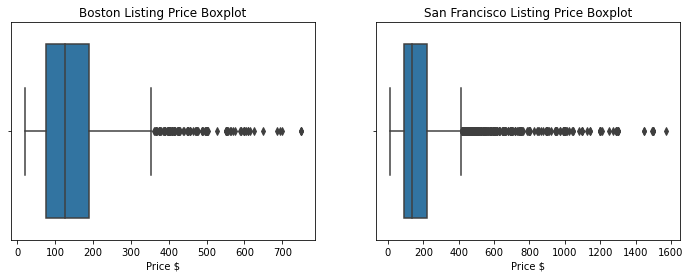

In [28]:
# Box Plot of price for Boston and San Francisco
fig, axes = plt.subplots(1,2,figsize=(12,4))

ax = sns.boxplot(ax=axes[0],x=bdf['price'])
ax.set_title("Boston Listing Price Boxplot")
ax.set_xlabel("Price $")

ax = sns.boxplot(ax=axes[1],x=sfdf['price'])
ax.set_title("San Francisco Listing Price Boxplot")
ax.set_xlabel("Price $")

In [29]:
# Change Categorical fields to One Hot encoding

cat_cols=['room_type','property_type'] 
cat_prefix=['rmt','ppt']

bdf = apply_get_dummies(bdf, cat_cols, cat_prefix)
sfdf = apply_get_dummies(sfdf, cat_cols, cat_prefix)

In [30]:
# List columns with limited number of values 

flags_set_threshold=20


# Inspect RoomType OneHot fields
for col in bdf.columns:
    if col.startswith('rmt'):
        if bdf[col].sum() < flags_set_threshold:
            print(col, bdf[col].sum())


# Inspect PropertType OneHot fields
for col in bdf.columns:
    if col.startswith("ppt"):
        if bdf[col].sum() < flags_set_threshold:
            print(col, bdf[col].sum())


rmt_Hotel_room 19
rmt_Shared_room 11
ppt_Boat 6
ppt_Casa_particular 1
ppt_Castle 1
ppt_Entire_guesthouse 4
ppt_Entire_home/apt 1
ppt_Entire_loft 17
ppt_Entire_place 3
ppt_Houseboat 1
ppt_Private_room_in_bungalow 2
ppt_Private_room_in_guest_suite 14
ppt_Private_room_in_guesthouse 1
ppt_Private_room_in_loft 8
ppt_Private_room_in_villa 2
ppt_Room_in_aparthotel 1
ppt_Room_in_bed_and_breakfast 1
ppt_Shared_room_in_apartment 4
ppt_Shared_room_in_bed_and_breakfast 2
ppt_Shared_room_in_boutique_hotel 1
ppt_Shared_room_in_condominium 1
ppt_Shared_room_in_house 2
ppt_Shared_room_in_townhouse 1


Some of the Room Type and Property Type categories listed above only have a small number of occurances. We may assume that they have little influence over price. We can confirm this by using a t test to compare records with and without each onehot feature having the value 1 or 0.  If no significant difference is found then we discard the onehot feature. A p value of 0.05 is used as a threshold to discriminate between effective and ineffective features. see below

### Room Stats

In [31]:
room_stats, drop_list = get_one_hot_stats(bdf,'rmt','price', 0.05)
print(drop_list)
room_stats

['rmt_Hotel_room', 'rmt_Shared_room']


,column_name,t_statistic,pvalue,mean_True,mean_False,count_true,mean_diff
0,rmt_Entire_home/apt,33.029380,2.590136e-205,184.720181,77.506239,1987,107.213942
1,rmt_Private_room,-33.345636,1.109202e-208,75.554945,184.181953,1092,-108.627008


In [32]:
bdf=bdf.drop(drop_list,axis=1)

### Property Types

In [33]:


property_stats, drop_list = get_one_hot_stats(bdf, 'ppt','price', 0.05)
print(drop_list)
property_stats

Rejecting column! ppt_Casa_particular , reason low count  1
Rejecting column! ppt_Castle , reason low count  1
Rejecting column! ppt_Entire_home/apt , reason low count  1
Rejecting column! ppt_Houseboat , reason low count  1
Rejecting column! ppt_Private_room_in_guesthouse , reason low count  1
Rejecting column! ppt_Room_in_aparthotel , reason low count  1
Rejecting column! ppt_Room_in_bed_and_breakfast , reason low count  1
Rejecting column! ppt_Shared_room_in_boutique_hotel , reason low count  1
Rejecting column! ppt_Shared_room_in_condominium , reason low count  1
Rejecting column! ppt_Shared_room_in_townhouse , reason low count  1
['ppt_Casa_particular', 'ppt_Castle', 'ppt_Entire_bed_and_breakfast', 'ppt_Entire_guesthouse', 'ppt_Entire_home/apt', 'ppt_Entire_loft', 'ppt_Entire_place', 'ppt_Houseboat', 'ppt_Private_room_in_bed_and_breakfast', 'ppt_Private_room_in_bungalow', 'ppt_Private_room_in_guest_suite', 'ppt_Private_room_in_guesthouse', 'ppt_Private_room_in_villa', 'ppt_Room_in

,column_name,t_statistic,pvalue,mean_True,mean_False,count_true,mean_diff
0,ppt_Boat,2.708256,6.800856e-03,257.500000,145.812440,6,111.687560
1,ppt_Entire_apartment,14.201438,2.134966e-44,176.643548,125.715891,1240,50.927658
2,ppt_Entire_condominium,4.548090,5.620568e-06,173.566929,143.577933,254,29.988996
3,ppt_Entire_guest_suite,-2.519672,1.179618e-02,109.212766,146.593076,47,-37.380310
4,ppt_Entire_house,12.847632,7.563147e-37,270.470000,141.892323,100,128.577677
5,ppt_Entire_serviced_apartment,10.397493,6.491311e-25,207.727626,140.468093,257,67.259534
6,ppt_Entire_townhouse,8.566096,1.659115e-17,306.964286,144.565401,28,162.398885
7,ppt_Private_room_in_apartment,-21.441488,3.152106e-95,62.494929,161.770260,493,-99.275331
8,ppt_Private_room_in_condominium,-6.449930,1.293125e-10,74.587500,147.914823,80,-73.327323
9,ppt_Private_room_in_house,-15.648110,3.483570e-53,72.314667,156.138625,375,-83.823958


In [34]:
bdf = bdf.drop(drop_list, axis=1)

### Amenity Strings
The amenities field contains data entered by users promoting listings describing features of their listings. This is stored as a json list of text descriptions of amenities and needs to be converted into one hot encoded fields. This categorical data needs to be one hot encoded so that it can be used to build models.


In [35]:
#invalid_chars =    ['#','@','&','$','"','\'','–','’','.',',','/','\\','\t','\r','\n']
invalid_chars_list=['#','@','&','$','"','\'','–','’','.',',','/','\\','\t','\r','\n']
def treat_column_name(column_name):
    column_name=column_name.replace(' ','_')
    column_name=column_name.lstrip().rstrip()
    column_name=column_name.replace(u"\u005F",'_')
    column_name=column_name.replace(u"\u2018",'\'')
    column_name=column_name.replace(u"\u2019",'\'')
    column_name=column_name.replace(u"\u2013",'-')
    column_name=column_name.replace('"','_')

    for char in invalid_chars_list:
        column_name=column_name.replace(char,'_')
        
    return column_name

#def treat_column_name_df(dataframe):
#    dataframe.columns=dataframe.columns.str.replace(' ','_')
#    dataframe.columns=dataframe.columns.str.replace(invalid_chars,'')

In [36]:
amenity_column = 'amenities'
amenity_prefix = 'amt'

Create lists of amenities. Also dictionary with count of each unique amenity.

In [37]:
# Extract amenity data into unique value list and list with duplicates to create dictionary with count

boston_unique_list=[]
boston_duplicate_list=[]
for jlist in  bdf.amenities.str.lower():
    amlist=json.loads(jlist)
    for item in amlist:
        boston_duplicate_list.append(item)
        if item not in boston_unique_list: 
            boston_unique_list.append(item )

            
sanfran_unique_list=[]
sanfran_duplicate_list=[]
for jlist in  sfdf.amenities.str.lower():
    amlist=json.loads(jlist)
    for item in amlist:
        sanfran_duplicate_list.append(item)
        if item.lower() not in sanfran_unique_list: 
            sanfran_unique_list.append(item )      

# Display amentiy list
print("Boston Amenities List Length = {}".format(len(boston_unique_list)))
print("San Francisco Amenities List Length = {}".format(len(sanfran_unique_list)))
print(boston_unique_list[:30])

Boston Amenities List Length = 328
San Francisco Amenities List Length = 600
['washer', 'dishwasher', 'refrigerator', 'patio or balcony', 'iron', 'heating', 'carbon monoxide alarm', 'wifi', 'free parking on premises', 'extra pillows and blankets', 'microwave', 'shampoo', 'air conditioning', 'hot water', 'cable tv', 'long term stays allowed', 'hair dryer', 'essentials', 'free street parking', 'coffee maker', 'stove', 'oven', 'hangers', 'cooking basics', 'dryer', 'dedicated workspace', 'bed linens', 'tv with standard cable', 'kitchen', 'dishes and silverware']


#### Create dictionary with counts of each unique amenity

In [38]:
# Boston Amenities
boston_count_amenities = dict()
for i in boston_duplicate_list:
    boston_count_amenities[i] = boston_count_amenities.get(i, 0) + 1

    
# Remove amenities with counts less than count_threshold
count_threshold = 15
for k, v in list(boston_count_amenities.items()):
    if v < count_threshold:
        del boston_count_amenities[k]

print("Number of different amenities =",len(boston_count_amenities))
print(list(map(lambda x: (x[0],  x[1] ), boston_count_amenities.items() ))[:30])

Number of different amenities = 122
[('washer', 2152), ('dishwasher', 1379), ('refrigerator', 2225), ('patio or balcony', 674), ('iron', 2549), ('heating', 2775), ('carbon monoxide alarm', 2805), ('wifi', 3018), ('free parking on premises', 542), ('extra pillows and blankets', 1285), ('microwave', 2227), ('shampoo', 2443), ('air conditioning', 2410), ('hot water', 2391), ('cable tv', 860), ('long term stays allowed', 2995), ('hair dryer', 2613), ('essentials', 2820), ('free street parking', 987), ('coffee maker', 2110), ('stove', 1769), ('oven', 1827), ('hangers', 2816), ('cooking basics', 1899), ('dryer', 2140), ('dedicated workspace', 2295), ('bed linens', 1904), ('tv with standard cable', 829), ('kitchen', 2812), ('dishes and silverware', 2045)]


#### Create One Hot Encoded fields for Boston Data

In [39]:
# Amenity Data
#boston_amenity_data= bdf[['price', amenity_column]].copy()
#boston_amenity_data=pd.DataFrame(boston_amenity_data)

In [40]:
# Crunch one hot encoding

def get_is_amenity_in_json(amenity,json_string):
    """
    Return true if amenity in json string false if not
    
    amenity - amenity to find
    json_string - string to search to find amenity
    """
    result=0
    amlist=json.loads(json_string)
   
    for amenity_str in amlist:
        if (amenity==amenity_str):
            result=1

    return result

for amenity in boston_unique_list:
    column_name = treat_column_name(amenity)
    column_name = "%s%s%s" % (amenity_prefix, "_", column_name)
    bdf[column_name]= bdf[amenity_column].apply(lambda jstr: get_is_amenity_in_json(amenity,jstr.lower()))

In [41]:
bdf.head(5)

,host_listings_count,host_total_listings_count,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,nhd_Brighton,nhd_Downtown,rmt_Entire_home/apt,rmt_Private_room,ppt_Boat,ppt_Entire_apartment,ppt_Entire_condominium,ppt_Entire_guest_suite,ppt_Entire_house,ppt_Entire_serviced_apartment,ppt_Entire_townhouse,ppt_Private_room_in_apartment,ppt_Private_room_in_condominium,ppt_Private_room_in_house,ppt_Private_room_in_loft,ppt_Private_room_in_townhouse,ppt_Room_in_hotel,amt_washer,amt_dishwasher,amt_refrigerator,amt_patio_or_balcony,amt_iron,amt_heating,amt_carbon_monoxide_alarm,amt_wifi,amt_free_parking_on_premises,amt_extra_pillows_and_blankets,amt_microwave,amt_shampoo,amt_air_conditioning,amt_hot_water,amt_cable_tv,amt_long_term_stays_allowed,amt_hair_dryer,amt_essentials,amt_free_street_parking,amt_coffee_maker,amt_stove,amt_oven,amt_hangers,amt_cooking_basics,amt_dryer,amt_dedicated_workspace,amt_bed_linens,amt_tv_with_standard_cable,amt_kitchen,amt_dishes_and_silverware,amt_smoke_alarm,amt_fire_extinguisher,amt_keypad,amt_luggage_dropoff_allowed,amt_lockbox,amt_freezer,amt_electric_stove,amt_bathtub,amt_smart_lock,amt_security_cameras_on_property,amt_pack__n_play_travel_crib,amt_paid_parking_off_premises,amt_host_greets_you,amt_indoor_fireplace,amt_backyard,amt_first_aid_kit,amt_breakfast,amt_elevator,amt_hot_tub,amt_tv,amt_private_entrance,amt_room-darkening_shades,amt_babysitter_recommendations,amt_ethernet_connection,amt_single_level_home,amt_cleaning_before_checkout,amt_lock_on_bedroom_door,amt_lake_access,amt_bbq_grill,amt_sound_system,amt_laundromat_nearby,amt_body_soap,amt_beach_essentials,amt_conditioner,amt_portable_fans,amt_outlet_covers,amt_ev_charger,amt_paid_parking_on_premises,amt_stainless_steel_gas_stove,amt_toaster,amt_pour-over_coffee,amt_dedicated_workspace:_office_chair_and_desk,amt_stainless_steel_oven,amt_wine_glasses,amt_barbecue_utensils,amt_baking_sheet,amt_dining_table,amt_shower_gel,amt_children_s_books_and_toys,amt_outdoor_furniture,amt_high_chair,amt_clothing_storage:_closet,amt_tv_with_roku,amt_paid_parking_garage_off_premises,amt_mini_fridge,amt_hot_water_kettle,amt_mini_fridge_refrigerator,amt_cleaning_products,amt_window_ac_unit,amt_ceiling_fan,amt_central_heating,amt_65__hdtv_with_netflix__hbo_max__amazon_prime_video__standard_cable,amt_board_games,amt_clothing_storage:_closet_and_dresser,amt_keurig_coffee_machine,amt_dedicated_workspace:_table,amt_crib,amt_clothing_storage:_dresser,amt_wifi_-_100_mbps,amt_beekman_shampoo,amt_paid_street_parking_off_premises,amt_beekman_conditioner,amt_tv_with_amazon_prime_video__hbo_max__netflix__roku__standard_cable,amt_safe,amt_building_staff,amt_children_s_dinnerware,amt_beekman_hotel_conditioner,amt_tv_with_hbo_max__netflix__roku__amazon_prime_video__standard_cable,amt_game_console,amt_changing_table,amt_loreal_conditioner,amt_washer_- in_building,amt_drying_rack_for_clothing,amt_outdoor_dining_area,amt_bikes,amt_dryer_-_in_building,amt_baby_safety_gates,amt_baby_bath,amt_piano,amt_fireplace_guards,amt_bread_maker,amt_bath___body_works_shampoo,amt_bath___body_works_conditioner,amt_paid_parking_garage_on_premises,amt_washer_- in_unit,amt_window_guards,amt_bath___body_works_body_soap,amt_dryer_- in_unit,amt_gym,amt_free_dryer-in_building,amt_free_washer-in_building,amt_tv_with_hbo_max__netflix__roku__standard_cable,amt_paid_washer-in_building,amt_wifi_-_90_mbps,amt_hdtv_with_netflix__hbo_max__amazon_prime_vide

In [42]:
# Print example of amenity data
bdf.loc[3,amenity_column]

'["Dishwasher", "Fire extinguisher", "Refrigerator", "Heating", "Wifi", "Carbon monoxide alarm", "Microwave", "Lockbox", "Air conditioning", "Cable TV", "Hot water", "Long term stays allowed", "Essentials", "Coffee maker", "Hangers", "Cooking basics", "Dedicated workspace", "Bed linens", "TV with standard cable", "Kitchen", "Dishes and silverware", "Smoke alarm"]'

In [43]:
# Test column names
cnt=0
for col in bdf.columns:
    if col.startswith(amenity_prefix):
            count_true = bdf[col].sum()
            if(count_true==0):
                print(col, count_true)
                cnt+=1
print(cnt)

0


#### Calculate statistics to identify features for Boston

In [44]:
boston_amenity_stats, boston_drop_list = get_one_hot_stats(bdf,'amt','price', 0.001)
print()
print(boston_drop_list)

Rejecting column! amt_65__hdtv_with_netflix__hbo_max__amazon_prime_video__standard_cable , reason low count  1
Rejecting column! amt_beekman_hotel_conditioner , reason low count  1
Rejecting column! amt_tv_with_hbo_max__netflix__roku__amazon_prime_video__standard_cable , reason low count  1
Rejecting column! amt_loreal_conditioner , reason low count  1
Rejecting column! amt_tv_with_hbo_max__netflix__roku__standard_cable , reason low count  1
Rejecting column! amt_wifi_-_90_mbps , reason low count  1
Rejecting column! amt_hdtv_with_netflix__amazon_prime_video__hbo_max__premium_cable__standard_cable , reason low count  1
Rejecting column! amt_32__hdtv_with_netflix__premium_cable__amazon_prime_video__hbo_max__standard_cable , reason low count  1
Rejecting column! amt_dedicated_workspace:_table__office_chair__and_desk , reason low count  1
Rejecting column! amt_sonos_and_amazon_tap_bluetooth_sound_system , reason low count  1
Rejecting column! amt_37__hdtv_with_amazon_prime_video__apple_tv

Rejecting column! amt_whrilpool_refrigerator , reason low count  1
Rejecting column! amt_bath___body_works__body_soap , reason low count  1
Rejecting column! amt_dedicated_workspace:_monitor_and_desk , reason low count  1
Rejecting column! amt_bose_soundtouch_with_bluetooth_sound_system_with_bluetooth_and_aux , reason low count  1
Rejecting column! amt_hdtv_with_amazon_prime_video , reason low count  1

['amt_carbon_monoxide_alarm', 'amt_wifi', 'amt_free_parking_on_premises', 'amt_air_conditioning', 'amt_hot_water', 'amt_long_term_stays_allowed', 'amt_dedicated_workspace', 'amt_dishes_and_silverware', 'amt_smoke_alarm', 'amt_keypad', 'amt_freezer', 'amt_electric_stove', 'amt_smart_lock', 'amt_security_cameras_on_property', 'amt_backyard', 'amt_first_aid_kit', 'amt_breakfast', 'amt_hot_tub', 'amt_babysitter_recommendations', 'amt_single_level_home', 'amt_cleaning_before_checkout', 'amt_lake_access', 'amt_sound_system', 'amt_laundromat_nearby', 'amt_beach_essentials', 'amt_portable_fans'

In [45]:
boston_amenity_stats.sort_values('pvalue', ascending=True)

,column_name,t_statistic,pvalue,mean_True,mean_False,count_true,mean_diff
35,amt_lock_on_bedroom_door,-23.083133,6.090168e-109,74.137733,166.802239,697,-92.664506
64,amt_gym,14.683883,3.021884e-47,202.338920,134.270995,537,68.067925
4,amt_iron,13.009814,1.022008e-37,156.788545,97.048214,2549,59.740330
8,amt_shampoo,12.711934,3.967922e-36,157.753991,103.015015,2443,54.738976
10,amt_hair_dryer,12.636936,9.851523e-36,155.757750,94.770161,2613,60.987588
...,...,...,...,...,...,...,...
71,amt_shared_garden_or_backyard,-3.605161,3.168621e-04,52.400000,146.481900,15,-94.081900
72,amt_free_dryer-in_unit,3.555918,3.822817e-04,249.333333,145.627704,12,103.705629
80,amt_dedicated_workspace:_desk_and_table,3.549135,3.922260e-04,399.000000,145.865143,2,253.134857
68,amt_stainless_steel_electric_stove,3.512864,4.496243e-04,231.705882,145.556921,17,86.148961


In [46]:
# Apply Boston Drop List
bdf = bdf.drop(boston_drop_list, axis=1)
print(bdf.shape)

(3109, 129)


In [47]:
type(bdf)

pandas.core.frame.DataFrame

#### San Francisco Amenity Data

In [48]:
# San Francisco Amenities
sanfran_count_amenities = dict()
for i in sanfran_duplicate_list:
    sanfran_count_amenities[i] = sanfran_count_amenities.get(i, 0) + 1

    
# Remove amenities with counts less than count_threshold
count_threshold = 15
for k, v in list(sanfran_count_amenities.items()):
    if v < count_threshold:
        del sanfran_count_amenities[k]

print("Number of different amenities =",len(sanfran_count_amenities))
print(list(map(lambda x: (x[0],  x[1] ), sanfran_count_amenities.items() ))[:30])

Number of different amenities = 138
[('keypad', 1065), ('backyard', 1661), ('hot water', 4712), ('long term stays allowed', 5433), ('oven', 2840), ('essentials', 6201), ('hangers', 5789), ('dryer', 4641), ('hair dryer', 5584), ('heating', 6173), ('dishes and silverware', 3669), ('iron', 5386), ('private entrance', 2948), ('shampoo', 5068), ('first aid kit', 3147), ('microwave', 3787), ('room-darkening shades', 658), ('cable tv', 2093), ('washer', 4656), ('stove', 2697), ('kitchen', 5146), ('dedicated workspace', 4863), ('wifi', 6433), ('cooking basics', 3084), ('refrigerator', 3884), ('free street parking', 2770), ('carbon monoxide alarm', 5659), ('smoke alarm', 6272), ('tv', 5365), ('pack ’n play/travel crib', 626)]


#### Create One Hot Encoded fields for San Francisco Data

In [49]:
# Amenity Data
#sanfran_amenity_data= sfdf[['price', amenity_column]].copy()
#sanfran_amenity_data=pd.DataFrame(sanfran_amenity_data)

In [50]:
for amenity in sanfran_unique_list:
    column_name = treat_column_name(amenity)
    column_name = "%s%s%s" % (amenity_prefix, "_", column_name)
    sfdf[column_name]= sfdf[amenity_column].apply(lambda jstr: get_is_amenity_in_json(amenity,jstr.lower()))

In [51]:
# Print example of amentity data
sfdf.loc[3,'amenities']

'["Long term stays allowed", "Washer", "Host greets you", "Smoke alarm", "Heating", "Free street parking", "Lock on bedroom door", "Kitchen", "TV", "Carbon monoxide alarm", "Fire extinguisher", "Private entrance", "Dryer", "Wifi", "Hot water"]'

#### Calculate statistics to identify features for San Francisco

In [52]:
sanfran_amenity_stats, sanfran_drop_list = get_one_hot_stats(sfdf,'amt','price', 0.001)
print(sanfran_drop_list)
sanfran_amenity_stats

Rejecting column! amt_37__hdtv_with_netflix__amazon_prime_video__hbo_max__chromecast , reason low count  1
Rejecting column! amt_36__hdtv_with_amazon_prime_video__netflix__roku , reason low count  1
Rejecting column! amt_hdtv_with_netflix__standard_cable , reason low count  1
Rejecting column! amt_50__tv_with_netflix__roku , reason low count  1
Rejecting column! amt_ivory_body_soap , reason low count  1
Rejecting column! amt_54__hdtv_with_roku__amazon_prime_video__netflix , reason low count  1
Rejecting column! amt_wifi_-_35_mbps , reason low count  1
Rejecting column! amt_43__hdtv_with_roku__amazon_prime_video__netflix , reason low count  1
Rejecting column! amt_hdtv_with_netflix__premium_cable , reason low count  1
Rejecting column! amt_kenmore_electric_range__oven , reason low count  1
Rejecting column! amt_dedicated_workspace:_office_chair__table__and_desk , reason low count  1
Rejecting column! amt_double_burner_black_decker_hotplate_electric_stove , reason low count  1
Rejecting 

Rejecting column! amt_120__tv_with_amazon_prime_video__netflix , reason low count  1
Rejecting column! amt_hdtv_with_roku , reason low count  1
Rejecting column! amt_single_use_tube_on_arrival_conditioner , reason low count  1
Rejecting column! amt_pre-amp__amp__cd_player__dvd_player_sound_system , reason low count  1
Rejecting column! amt_4_burners_and_double_oven_electronic_control_stainless_steel_gas_stove , reason low count  1
Rejecting column! amt_single_use_tube_on_arrival_shampoo , reason low count  1
Rejecting column! amt_dove_fragrance_free_body_soap , reason low count  1
Rejecting column! amt_wifi_-_90_mbps , reason low count  1
Rejecting column! amt_48__hdtv_with_amazon_prime_video__apple_tv__hbo_max__netflix , reason low count  1
Rejecting column! amt_misc_body_soap , reason low count  1
Rejecting column! amt_clothing_storage:_wardrobe_and_dresser , reason low count  1
Rejecting column! amt_misc_conditioner , reason low count  1
Rejecting column! amt_whirlpool_electric__ele

Rejecting column! amt_sonos__bluetooth_sound_system , reason low count  1
Rejecting column! amt_42__hdtv_with_premium_cable , reason low count  1
Rejecting column! amt_clothing_storage:_walk-in_closet__wardrobe__and_dresser , reason low count  1
Rejecting column! amt_aveda_conditioner , reason low count  1
Rejecting column! amt_aveda_shampoo , reason low count  1
Rejecting column! amt_share_with_other__refrigerator , reason low count  1
Rejecting column! amt_single_electric_burner_electric_stove , reason low count  1
Rejecting column! amt_single_electric_burner_gas_stove , reason low count  1
Rejecting column! amt_lg_soundbar_with_record_player_sound_system_with_bluetooth_and_aux , reason low count  1
Rejecting column! amt_lg_stainless_steel_electric_stove , reason low count  1
Rejecting column! amt_49__hdtv_with_chromecast__netflix__hbo_max__apple_tv__amazon_prime_video , reason low count  1
Rejecting column! amt_garnier__conditioner , reason low count  1
Rejecting column! amt_fridgid

,column_name,t_statistic,pvalue,mean_True,mean_False,count_true,mean_diff
0,amt_keypad,-3.480943,5.028669e-04,168.201878,187.756010,1065,-19.554132
1,amt_backyard,5.146473,2.730527e-07,202.966887,178.497188,1661,24.469700
2,amt_long_term_stays_allowed,-8.468214,3.036431e-17,176.430701,221.508292,5433,-45.077591
3,amt_oven,3.432400,6.019169e-04,192.803521,178.500921,2840,14.302600
4,amt_essentials,-6.668254,2.797103e-11,180.974520,236.219178,6201,-55.244658
...,...,...,...,...,...,...,...
68,amt_paid_valet_parking_on_premises_-__65_per_day,5.183271,2.244675e-07,799.500000,184.433931,2,615.066069
69,amt_ironing_board,6.403935,1.617760e-10,943.500000,184.390538,2,759.109462
70,amt_smart_tv,6.403935,1.617760e-10,943.500000,184.390538,2,759.109462
71,amt_terrace,6.403935,1.617760e-10,943.500000,184.390538,2,759.109462


In [53]:
# Apply San Francisco amenity drop list
sfdf = sfdf.drop(sanfran_drop_list, axis=1)
print(sfdf.shape)

(6639, 163)


In [54]:
# drop the amenity column now we are done with it
bdf=bdf.drop(amenity_column,axis=1)
sfdf=sfdf.drop(amenity_column,axis=1)

In [55]:
print("bdf shape",bdf.shape)
print("sfdf shape",sfdf.shape)

bdf shape (3109, 128)
sfdf shape (6639, 162)


### Feature Selection

In [56]:
# pearsons R
boston_correlation = pd.DataFrame(bdf.corr()['price']).sort_values('price', ascending=False)
boston_correlation.columns=['corr']
boston_correlation['abs_corr']= np.abs(boston_correlation['corr'])
boston_top_12 = boston_correlation.head(13).sort_values('abs_corr', ascending=False)
boston_top_12=boston_top_12.drop( boston_top_12[ boston_top_12['corr']==1.0 ].index)
boston_top_12['column_name']=boston_top_12.index
boston_top_12['column_name']=boston_top_12['column_name'].astype(str)
boston_top_12.index=range(12)
boston_top_12


,corr,abs_corr,column_name
0,0.602689,0.602689,accommodates
1,0.509779,0.509779,rmt_Entire_home/apt
2,0.501822,0.501822,beds
3,0.484670,0.484670,bedrooms
4,0.305861,0.305861,bathrooms_text
5,0.254742,0.254742,amt_gym
6,0.246891,0.246891,ppt_Entire_apartment
7,0.227291,0.227291,amt_iron
8,0.224601,0.224601,ppt_Entire_house
9,0.222347,0.222347,amt_shampoo


The highest correlation coefficient is 0.6 here and most are much smaller. That means that fitting models to this data with small errors will not be possible.
The above list is a short list of the top twelve features some of these are one hot encoded features.

In [57]:
from sklearn.linear_model import LinearRegression
import numpy as np

class Line:
    
    def __init__(self,coeff,intercept,name):
        self.coeff=coeff
        self.intercept=intercept
        self.name=name
        self.x_vals=[]
        self.y_vals=[]
        
    def get_plot(self,axes):
        self.x_vals = np.array(axes.get_xlim())
        self.y_vals = self.intercept + self.coeff * self.x_vals
           
lines = []
reg_dataset=pd.DataFrame()
picked = boston_top_12['column_name']
reg_dataset = bdf[picked]
        
for col in reg_dataset.columns:
    
    xvals=bdf[col].to_numpy().reshape(-1,1)
    yvals=bdf[target_name].to_numpy()
    
    lm = LinearRegression()
    lm.fit(xvals, yvals)
    lines.append(Line(lm.coef_, lm.intercept_, col))

In [58]:
reg_dataset

,accommodates,rmt_Entire_home/apt,beds,bedrooms,bathrooms_text,amt_gym,ppt_Entire_apartment,amt_iron,ppt_Entire_house,amt_shampoo,amt_hair_dryer,amt_dishwasher
0,2,1,0.0,1.0,1.0,0,1,1,0,1,1,1
1,4,1,1.0,1.0,1.0,0,0,1,0,1,1,1
2,3,1,1.0,0.0,1.0,0,1,1,0,1,1,1
3,2,1,1.0,0.0,1.0,0,0,0,0,0,0,1
4,1,1,0.0,0.0,1.0,0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3137,2,0,1.0,1.0,1.0,0,0,1,0,0,0,0
3138,7,1,0.0,3.0,3.0,1,0,1,0,1,1,1
3139,3,1,0.0,1.0,1.0,1,0,1,0,1,1,0
3140,1,1,0.0,0.0,1.0,1,0,1,0,1,1,0


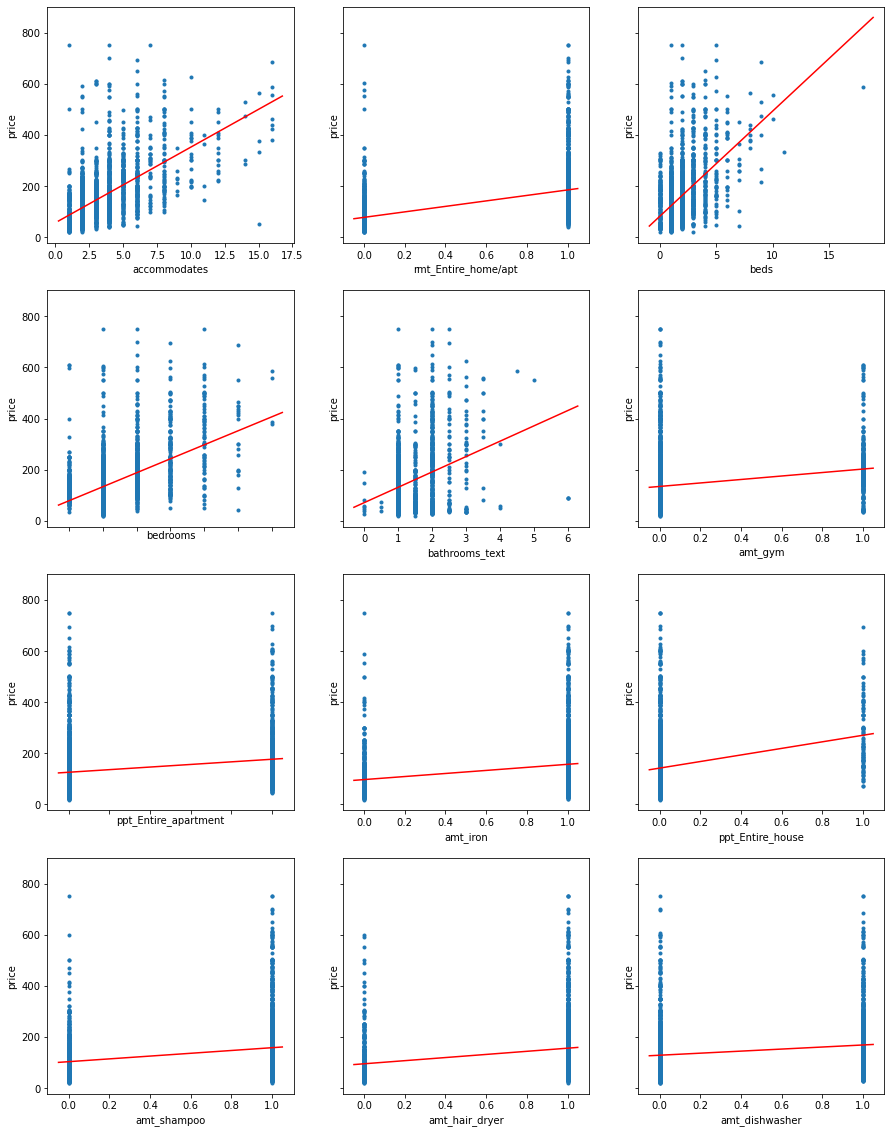

In [59]:
# Plot scatter plots of best features with regression lines on them

xdim=3
ydim=4
xlim=xdim-1
ylim=ydim-1

fig, ax = plt.subplots(ydim, xdim, figsize=(15, 20), sharey=True)

dot_size = (plt.rcParams['lines.markersize']/2) ** 2

sx,sy = 0,0
cnt=0
for col in reg_dataset.columns:

    ax[sy,sx].scatter(x=bdf[col], y=bdf[target_name], s=dot_size)
    
    
    ln = lines[cnt]
    ln.get_plot(ax[sy,sx])
    ax[sy,sx].plot(ln.x_vals,ln.y_vals,'r')

    ax[sy,sx].set_xlabel(col)
    ax[sy,sx].set_ylabel(target_name)
    
    
    sx+=1
    if sx > xlim and sy < ylim:
        sx=0
        sy+=1
        ax[sy,sx].label_outer()
        
    cnt+=1

plt.show()
plt.close()

These plots illustrate the data we are using linear regression to model.

### Linear Regression

There are four assumptions associated with the use of linear regression models.

1. Linearity: The relationship between X and the mean of Y is linear.
2. Homoscedasticity: The variance of residual is the same for any value of X.
3. Independence: Observations are independent of each other.
4. Normality: For any fixed value of X, Y is normally distributed (Errors are normally distributed).

We need to ask if these assumptions can be made of the data used here so that we can decide if using a linear regression model is valid here. Looking at the scatter plots above there is certainly some doubt about the quality of some of the features.

In [60]:
# Fix the spaces in columns name issue using get_dummies
bdf.columns = bdf.columns.map(lambda x : x.replace(' ','_'))
sfdf.columns= sfdf.columns.map(lambda x : x.replace(' ','_'))

In [61]:
# Apply MinMaxScalar

cols=list(bdf.columns)
cols.remove(target_name)

bdf = apply_min_max_scalar_to_columns(bdf, cols)

cols=list(sfdf.columns)
cols.remove(target_name)

sfdf = apply_min_max_scalar_to_columns(sfdf, cols)


### Export Data

In [62]:
# Export Tidied datafiles
data_to_csv(bdf,"bdf_long.csv")
data_to_csv(sfdf,"sfdf_long.csv")